In [14]:
import pandas as pd
pd.set_option('display.max_columns', None)  #显示全部列
pd.set_option('display.max_rows', None)    #显示全部行
import numpy as np
import os
import pymongo
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_selection import RFECV
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages
from utils import load_xy, ini_tree, ini_tree_choose, load_config, loc_zq_collection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.feature_selection import RFE
from tscv import GapWalkForward
import warnings
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False  # 负号显示
%matplotlib inline

import matplotlib.ticker as ticker
warnings.filterwarnings("ignore")

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
X = pd.read_excel('x_sw_coal_features.xlsx', index_col=0)
X.index = [i.strftime("%Y-%m-%d") for i in X.index]
Y = pd.read_excel('y_ppi.xlsx', index_col=0)['PPI:煤炭开采和洗选业:当月同比']
Y.index = [i.strftime("%Y-%m-%d") for i in Y.index]
x_data = X[:85]
y_data = Y[:85]
print('get the x_data and y_data!!!')

get the x_data and y_data!!!


> 首先剔除x_data销量

In [29]:
filter_x = [x_data.columns[i] for i in range(len(x_data.columns))  if '销量' not in x_data.columns[i]]
x_data = x_data[filter_x]
x_data

,期货结算价(活跃合约):焦炭,期货收盘价(活跃合约):焦炭,期货结算价(连续):焦炭,期货结算价(连三):焦炭,期货收盘价(连续):焦炭,期货收盘价(连三):焦炭,期货结算价(活跃合约):焦煤,期货收盘价(活跃合约):焦煤,期货结算价(连续):焦煤,期货结算价(连三):焦煤,期货收盘价(连续):焦煤,期货收盘价(连三):焦煤,期货收盘价(活跃合约):动力煤,期货结算价(活跃合约):动力煤,期货收盘价(连续):动力煤,期货结算价(连续):动力煤,期货收盘价(连三):动力煤,秦皇岛港:平仓价:动力末煤(Q5500):山西产,"市场价:动力煤(Q5800,晋城产):山西",期货结算价(连续):布伦特原油,"车板价:动力煤(Q5300,鄂尔多斯产):内蒙古",期货收盘价(连续):铁矿石,"市场价:动力煤(5000,兖州产):山东","市场价:动力煤(Q5500,山西产):秦皇岛","市场价:动力煤(Q5200,徐州产):江苏","市场价:动力煤(Q5000,淮南产):安徽","市场价:动力煤(Q4000,平顶山产):河南","市场价:动力煤(Q5500,山西产):广东",平均价:九级焦煤:临汾,平均价:十级焦煤:太原,平均价:主焦煤:邢台,平均价:十级焦煤:开滦,平均价:十级精煤:平顶山,平均价:1/3焦煤:淮南,平均价:九级1/3焦煤:淮北,平均价:七级气煤:泰安,"市场价:二级冶金焦(A<13.5%,S<0.75%,Mt<7.0%,M25>88%,CSR55%,淮北产):安徽","市场价:二级冶金焦(A<13.0%,S<0.8%,Mt<8%,M25>90%,CSR>52%,徐州产):江苏","市场价:二级冶金焦(A<13.0%,S<0.7%,Mt<7%,M25>90%,CSR52-55%,枣庄产):山东","市场价:二级冶金焦(A<13.5%,S<0.75%,Mt<10%,M25>90%,CSR>55%,临汾产):山西","车板价:二级冶金焦(A<13.5%,S<0.6%,Mt<5%,M40>76%,平顶山产):河南","市场价:二级冶金焦(A<13.5%,S1%,M25>90%,CSR55%,邵东产):湖南","市场价:二级冶金焦(A<13.0%,S<0.7%,Mt<8%,M25>88%,CSR52-55%,唐山产):河北","车板价:二级冶金焦(A<13.5%,S<0.8%,Mt<8%,M40>82%,CSR>60%,乌海产):内蒙古","车板价:二级冶金焦(A<12.5%,S<0.75%,Mt<7%,M25>88%,CSR>52%,韩城产):陕西","市场价:二级冶金焦(A<13.5%,S<0.8%,Mt<6.0%,M25>90%,CSR>55%,银川产):宁夏","车板价:二级冶金焦(A<13.5%,Mt<5%,M25>88%,CSR55%,七台河产):黑龙江","市场价:二级冶金焦(A<15%,S<0.6%,Mt<7.0%,C>83%,昆明产):云南","市场价:二级冶金焦(A<14.0%,S<0.6%,Mt<7.0%,M40>80%,CSR>55%,六盘水产):贵州"
2015-01-31,-24.091920,-24.074074,-20.216049,-24.091920,-20.293210,-24.074074,-21.659483,-21.659483,-18.463303,-21.659483,-18.463303,-21.659483,-13.481481,-13.343217,-8.721360,-8.694044,-13.481481,-9.090909,-10.416667,-50.197368,1.176471,-39.433294,-15.929204,-13.559322,-18.750000,-9.821429,-16.981132,-12.781955,-30.357143,-23.333333,-8.823529,-22.641509,-15.178571,-18.783386,-18.395815,-21.893491,-25.899281,-26.277372,-24.812030,-25.000000,-22.058824,-18.750000,-22.137405,-20.192308,-24.786325,-22.340426,-22.807018,-13.414634,-19.463087
2015-02-28,-19.827586,-19.795758,-16.074313,-18.828125,-16.074313,-18.445840,-20.327869,-20.655738,-9.272300,-21.827957,-9.272300,-21.659483,-15.195531,-15.227103,-7.247465,-5.482538,-14.105887,-11.926606,-8.510638,-42.624003,1.176471,-39.260143,-11.214953,-9.909910,-13.333333,-9.821429,-12.000000,-12.307692,-23.039216,-19.767442,-20.588235,-20.000000,-15.887850,-21.349595,-11.111111,-18.934911,-21.951220,-20.325203,-20.833333,-21.212121,-18.181818,-13.740458,-20.000000,-15.625000,-19.047619,-21.978022,-16.190476,-10.691824,-11.111111
2015-03-31,-23.270952,-22.950820,-2.155576,-20.787930,-2.155576,-21.381032,-19.053254,-18.540670,-19.415205,-12.607099,-19.036428,-12.607099,-19.552861,-20.060446,-14.078596,-14.078596,-9.732824,-15.094340,-10.638298,-48.858575,-1.176471,-32.994924,-9.900990,-11.320755,-16.666667,-15.178571,-15.000000,-8.800000,-16.470588,-9.210526,-5.813953,-20.000000,-12.621359,-13.574278,-12.652259,-21.301775,-19.130435,-13.725490,-18.867925,-14.117647,-12.380952,-16.806723,-16.814159,-18.181818,-18.750000,-20.481928,-11.578947,-10.389610,-15.384615
2015-04-30,-22.170213,-21.655232,-17.786187,-20.775261,-16.650391,-20.844212,-19.249395,-18.757613,-8.085382,-17.931457,-4.933333,-17.992656,-22.430608,-22.155237,-27.591463,-25.640046,-22.930904,-22.429907,-21.276596,-38.206718,-5.882353,-44.518072,-13.861386,-17.924528,-21.929825,-15.178571,-15.000000,-8.064516,-17.073171,-5.479452,-2.409639,-21.000000,-19.417476,-13.574278,-9.533015,-21.301775,-23.636364,-18.627451,-23.809524,-20.930233,-20.388350,-20.168067,-18.518519,-22.727273,-22.580645,-27.710843,-9.677419,-18.543046,-22.834646
2015-05-31,-20.952381,-21.009491,-15.754813,-20.952381,-12.931937,-21.009491,-16.115196,-16.097561,-10.915033,-16.115196,-10.915033,-16.097561,-16.751468,-16.725421,-24.444444,-24.906925,-16.751468,-22.857143,-27.659574,-40.078603,-5.882353,-34.375000,-24.752475,-23.364486,-29.824561,-25.000000,-28.000000,-11.475410,-17.073171,-5.479452,-2.409639,-21.000000,-16.161616,-13.574278,-9.533015,-27.810651,-25.454545,-20.588235,-25.714286,-22.093023,-22.641509,-21.848739,-18.518519,-22.727273,-22.580645,-27.710843,-11.82

In [30]:
x_data.shape

(85, 49)

> 再按Bool Accuracy 过滤

In [45]:
dire = pd.DataFrame(index = x_data.columns)
dire.index.name = 'x'
dire.name = 'direction'

In [92]:
def direction(x):
    
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

In [106]:
dire_list = [list(map(direction,list(x_data.iloc[i+1]-x_data.iloc[i]))) for i in range(x_data.shape[0]-1)]
dire_data = pd.DataFrame(dire_data,columns=x_data.columns)
y = [direction(y_data.iloc[i+1]-y_data.iloc[i]) for i in range(y_data.shape[0]-1)]
# 没有第一期，注意索引数少1

In [141]:
def zero_count(x):
    return x[x == 0].count()
zero_data = pd.Series([zero_count(dire_data.iloc[:,i]) for i in range(dire_data.shape[1])],index = dire_data.columns)


In [137]:
def bo_corr(seri,y):
    return seri[seri * y >= 0].count()/len(seri)

bo_data = [bo_corr(dire_data.iloc[:,i],y) for i in range(dire_data.shape[1])]
bo_data = pd.Series(bo_data, index = dire_data.columns)

In [162]:
score = pd.DataFrame(index = dire_data.columns)
score['bo_score'] = bo_data
score['zero_num'] = zero_data

In [168]:
score.sort_values(by =['bo_score'],ascending=False)

,bo_score,zero_num
x,,
平均价:九级1/3焦煤:淮北,0.928571,43
"市场价:动力煤(Q4000,平顶山产):河南",0.892857,45
平均价:1/3焦煤:淮南,0.892857,43
平均价:主焦煤:邢台,0.869048,33
平均价:十级精煤:平顶山,0.857143,34
"市场价:动力煤(Q5000,淮南产):安徽",0.857143,34
平均价:十级焦煤:开滦,0.845238,19
"市场价:二级冶金焦(A<15%,S<0.6%,Mt<7.0%,C>83%,昆明产):云南",0.845238,45
"市场价:动力煤(Q5200,徐州产):江苏",0.833333,29


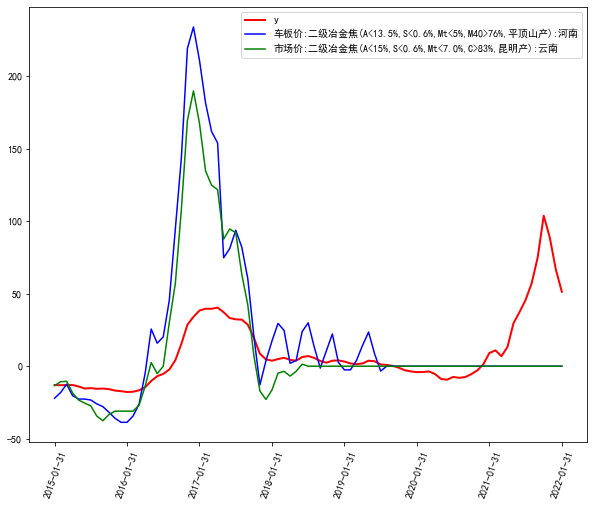

In [181]:
fig = plt.figure(figsize = (10,8))
fig = fig.add_subplot(1,1,1)
tick_spacing = 12
plt.plot(y_data,color = 'r',linewidth = 2,label = 'y')
plt.plot(x_data['车板价:二级冶金焦(A<13.5%,S<0.6%,Mt<5%,M40>76%,平顶山产):河南'],color = 'b',label='车板价:二级冶金焦(A<13.5%,S<0.6%,Mt<5%,M40>76%,平顶山产):河南')
plt.plot(x_data['市场价:二级冶金焦(A<15%,S<0.6%,Mt<7.0%,C>83%,昆明产):云南'],color = 'g',label = '市场价:二级冶金焦(A<15%,S<0.6%,Mt<7.0%,C>83%,昆明产):云南')
plt.legend()
fig.tick_params(axis='x', labelsize=10, rotation=70)
fig.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

删去【车板价:二级冶金焦(A<13.5%,S<0.6%,Mt<5%,M40>76%,平顶山产):河南】和【市场价:二级冶金焦(A<15%,S<0.6%,Mt<7.0%,C>83%,昆明产):云南】这俩指标。

In [184]:
x_data = x_data.drop(['车板价:二级冶金焦(A<13.5%,S<0.6%,Mt<5%,M40>76%,平顶山产):河南','市场价:二级冶金焦(A<15%,S<0.6%,Mt<7.0%,C>83%,昆明产):云南'],axis = 1)

In [186]:
x_data.shape

(85, 47)

In [187]:
#3折时间序列交叉验证集
tscv = TimeSeriesSplit(n_splits=3,max_train_size=x_data.shape[0]-12)
gcv = GapWalkForward(n_splits=5,gap_size=2,test_size=6)

lre = LinearRegression() #线性回归模型
ela = ElasticNet(alpha = 1) #弹性网络模型
las = Lasso(alpha = 1) # Lasso
rid = Ridge(alpha =1)

14
47
LinearRegression() 

[[-2.96595426e+00  6.40257268e-01  3.92542073e-01  7.76915163e-01
  -1.35918419e+01]
 [-8.35033846e+00 -1.54807801e+00  5.17309652e-01 -7.82137735e-03
  -1.27682785e+01]
 [-1.75220071e+00 -2.45188998e+00  7.87844484e-01  4.45658268e-02
  -2.28461711e+00]
 [-1.75883307e+00 -6.18802923e-01  6.54205454e-01  9.68931160e-03
  -1.39202086e+00]
 [-1.15092182e+00  4.55313238e-01  6.39460358e-01  4.46979657e-02
  -2.09166842e+00]
 [-1.08677706e+00 -6.92351967e-02  7.46694017e-01 -6.73555485e-01
  -1.52810061e+00]
 [-3.90039606e+00  1.85218327e-01  6.28146264e-01 -4.17915034e-01
  -1.37194319e+00]
 [-4.50019974e+00 -1.37256305e-01  3.18051732e-01 -4.20205412e-01
  -1.26148112e+00]
 [-5.59638956e+00 -1.27201966e-01  3.83321511e-01 -4.56557930e-01
  -9.30886891e-01]
 [-5.59605591e+00 -2.25068330e-01  3.76332539e-01 -4.56362191e-01
  -6.83592146e-01]
 [-2.13489716e+00 -3.54130751e-01  2.39412763e-01 -1.95366126e-01
  -4.28704735e-01]
 [-9.60860735e-01 -3.34585554e-01  3.5

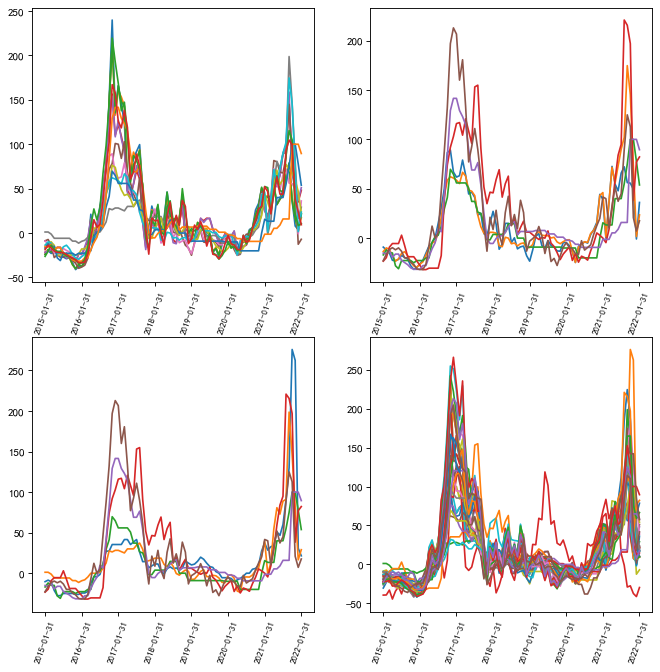

In [188]:
    method = [lre,ela,las,rid]
    k=0
    fig = plt.figure(figsize=(10,10),dpi=80)
    tick_spacing = 12
    for i in method:
        fet = pd.DataFrame()
        rfe = RFECV(estimator=i,step=1,cv=gcv).fit(x_data,y_data)
        k += 1
        sup = rfe.support_
        fet= x_data[x_data.columns[sup]]
#         print(fet)

        # print(rfe.support_)
        # print(rfe.ranking_)
        print(rfe.n_features_)
        print(rfe.n_features_in_)
        # print(rfe.feature_names_in_)
        print(rfe.estimator_,'\n')
        print(rfe.grid_scores_[sup])
        print('\n')
        ax = fig.add_subplot(2,2,k)
        ax.tick_params(axis='x', labelsize=8, rotation=70)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.plot(fet.index,fet)
        

In [14]:
x_data_ = x_data
for train,test in tscv.split(x_data_):
    # print(x_data.iloc[train],x_data.iloc[test])
    # print(y_data.iloc[train],y_data.iloc[test])
    x_train = x_data_.iloc[train]
    x_test = x_data_.iloc[test]
    y_train = y_data.iloc[train]
    y_test = y_data.iloc[test]
    lre.fit(x_train,y_train)
    ela.fit(x_train,y_train)
    las.fit(x_train,y_train)
    rid.fit(x_train,y_train)
    y_lre = lre.predict(x_test)
    y_ela = ela.predict(x_test)
    y_las = las.predict(x_test)
    y_rid = rid.predict(x_test)
    print(lre.coef_[0:10])
    print(mae(y_test,y_lre))
    print(ela.coef_[0:10])
    print(mae(y_test,y_ela))
    print(las.coef_[0:10])
    print(mae(y_test,y_las))
    print(rid.coef_[0:10])
    print(mae(y_test,y_rid))

[0.00437178 0.00387679 0.00603702 0.00249503 0.00716455 0.00266812
 0.00308872 0.00239913 0.00567354 0.00256158]
21.811856124767917
[0.12448686 0.00403354 0.00904882 0.         0.00013162 0.
 0.         0.         0.         0.        ]
18.851674959643383
[0.11148797 0.         0.01667068 0.         0.00100493 0.
 0.         0.         0.         0.        ]
19.573987838836715
[0.00437178 0.00387679 0.00603701 0.00249505 0.00716453 0.00266813
 0.00308872 0.00239914 0.00567352 0.00256158]
21.811855150384556
[-0.00521991 -0.0067086  -0.01838303  0.00204667  0.00925498 -0.00103452
 -0.00592195 -0.00730156  0.00316212 -0.02024265]
8.718129425367636
[ 0.13515859  0.          0.02118096  0.00085554  0.02079572 -0.00735383
 -0.01089947 -0.01118905  0.05038549 -0.05804021]
10.109096992937761
[ 0.07841395  0.          0.02956922  0.          0.02612892 -0.
 -0.         -0.01016616  0.04698543 -0.05708622]
11.4004203524664
[-0.00522001 -0.00670878 -0.01838257  0.00204659  0.00925476 -0.00103469


C:\Users\GPU_Tjdhf\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20753456278595062, tolerance: 0.13789386363636363
  model = cd_fast.enet_coordinate_descent(
C:\Users\GPU_Tjdhf\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34992524197360636, tolerance: 0.13789386363636363
  model = cd_fast.enet_coordinate_descent(
C:\Users\GPU_Tjdhf\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.744252439615211, tolerance: 1.7506024651162793
  model = cd_fast.enet_coordinate_descent(
C:\Users\GPU_Tjdhf\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

In [192]:
    method = [lre,ela,las,rid]
    k=0
    mae2 =[]
    cmm =[[],[],[],[]]
    for i in method:
        rfe = RFECV(estimator=i,step=1,cv=gcv).fit(x_data,y_data)
        k += 1
        sup = rfe.support_
        result = rfe.cv_results_
        col = x_data.columns[sup]

        x_new = x_data[col]
        cmm[k-1] = col
        # print(x_data.columns[sup])
        # print(x_new.head())
        print(rfe.estimator_)
        print(x_data[col].shape)


        mae1 = []
        for train,test in  gcv.split(range(x_new.shape[0])):
            x_train = x_new.iloc[train]
            x_test = x_new.iloc[test]
            y_train = y_data.iloc[train]
            y_test = y_data.iloc[test]

            for j in method:
                j.fit(x_train,y_train)
                y_pred = j.predict(x_test)
                mae1.append(mae(y_test,y_pred))
        mae2.append(np.mean(mae1))

    print(mae2)
    print(mae2.index(min(mae2)),min(mae2))
    

LinearRegression()
(85, 14)
ElasticNet(alpha=1)
(85, 6)
Lasso(alpha=1)
(85, 6)
Ridge(alpha=1)
(85, 36)
[5.7147938583172095, 6.378421451711428, 5.879731635902777, 7.147833033016026]
0 5.7147938583172095


                                                            VIF
x                                                              
期货收盘价(活跃合约):焦炭                                       196.193452
期货结算价(连三):焦炭                                        1885.999545
期货收盘价(连三):焦炭                                        2558.629773
期货结算价(活跃合约):焦煤                                      1670.945055
期货收盘价(活跃合约):焦煤                                      1422.835427
期货收盘价(连续):动力煤                                         24.888071
秦皇岛港:平仓价:动力末煤(Q5500):山西产                              21.926517
车板价:动力煤(Q5300,鄂尔多斯产):内蒙古                              15.017186
市场价:动力煤(5000,兖州产):山东                                  19.162944
市场价:动力煤(Q5500,山西产):秦皇岛                                38.899270
市场价:动力煤(Q4000,平顶山产):河南                                18.072810
平均价:十级精煤:平顶山                                          13.083332
市场价:二级冶金焦(A<13.0%,S<0.8%,Mt<8%,M25>90%,CSR>52%,...   107.023059
市场价:二级冶金焦(A<13.5%,S1%,M25>90%,CSR55%,邵东产

<Figure size 504x504 with 0 Axes>

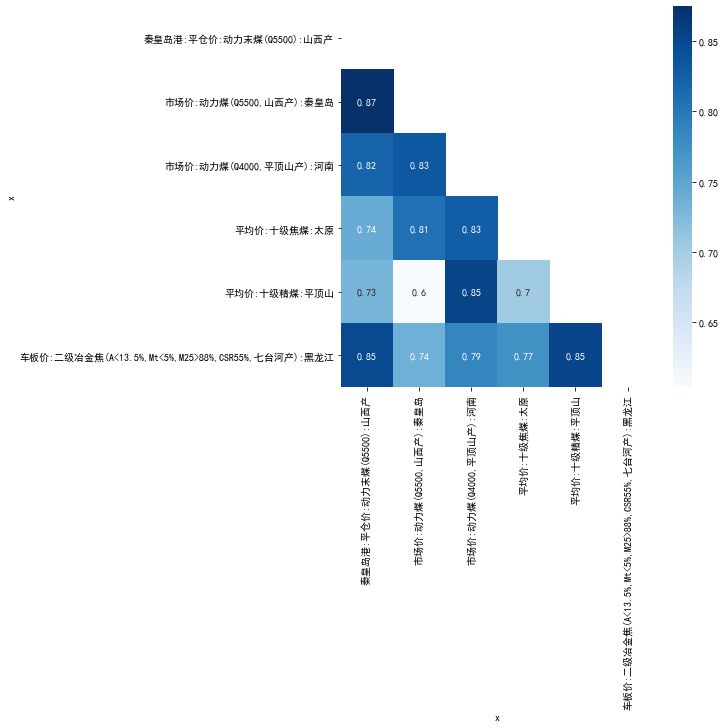

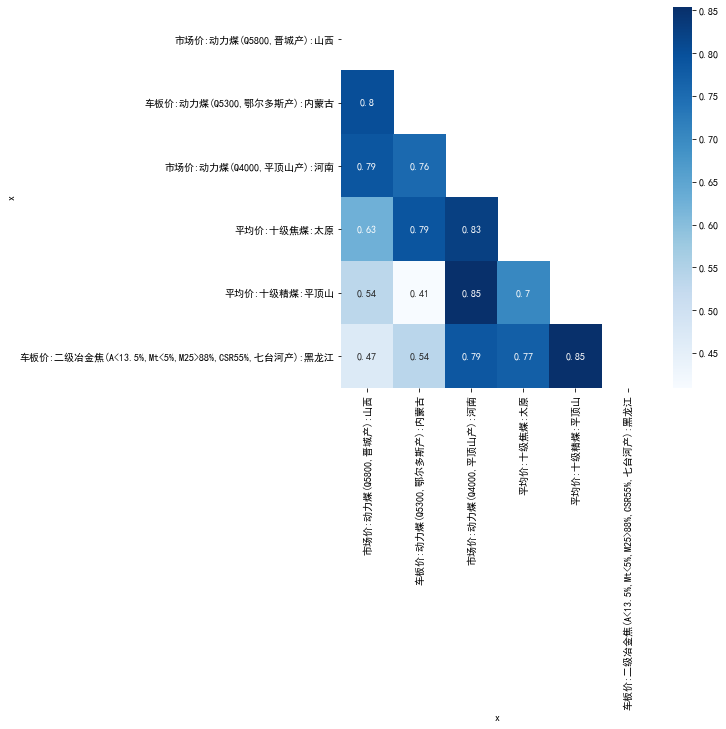

<Figure size 504x504 with 0 Axes>

In [215]:

mean=[]
for i in range(len(mae2)):
    fig = plt.figure(figsize=(7,7))
    fig.title = method[i]
    feature = cmm[i]
    x_select = x_data[feature]
    cor = x_select.corr()
    mask = np.zeros_like(cor)
    mask[np.tril_indices_from(mask)] = True
    
    
    # x_select.to_excel('x_select1.0.xlsx',index=True)
    #     print(x_select.shape)
    vif = [variance_inflation_factor(x_select.values, x_select.columns.get_loc(i)) for i in x_select.columns]
    vif_table = pd.DataFrame(vif ,index = x_select.columns)
    vif_table.columns = ['VIF']
    print(vif_table)
    mean.append(np.mean(vif_table['VIF']))
    print('mean:\n',np.mean(vif_table))
#     print(list(zip(list(x_select.columns), vif)))
    if np.mean(vif_table['VIF']) < 100:
        sns_plot = sns.heatmap(cor, annot=True,cmap='Blues',mask = mask.T)
        

mae_vif = pd.DataFrame(mae2,index = method)
mae_vif['vif'] = mean
print(mae_vif)

In [253]:
mae_vif.columns=(['mae','vif'])

0                            秦皇岛港:平仓价:动力末煤(Q5500):山西产
1                              市场价:动力煤(Q5500,山西产):秦皇岛
2                              市场价:动力煤(Q4000,平顶山产):河南
3                                         平均价:十级焦煤:太原
4                                        平均价:十级精煤:平顶山
5    车板价:二级冶金焦(A<13.5%,Mt<5%,M25>88%,CSR55%,七台河产):黑龙江
Name: x, dtype: object 

mae    6.378421
vif    8.753955
Name: ElasticNet(alpha=1), dtype: float64


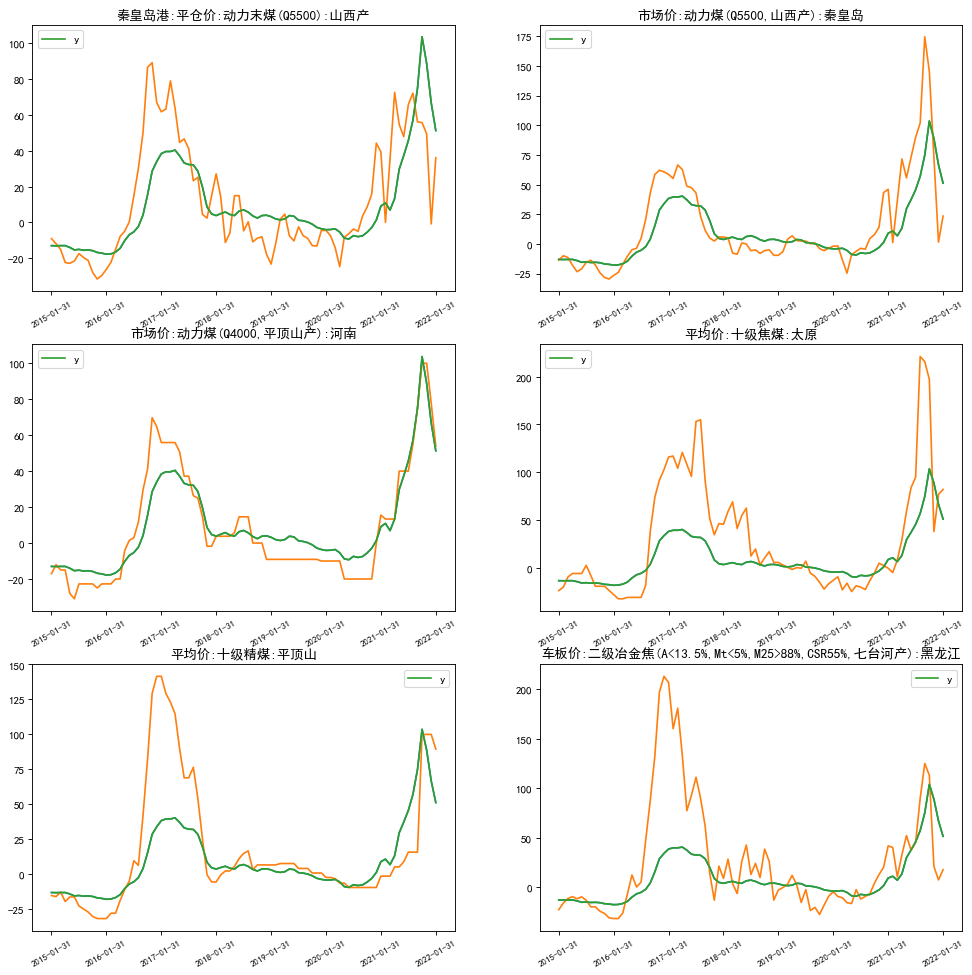

In [268]:
data = x_data[cmm[1]]
fig = plt.figure(figsize=(15,15),dpi=80)
print(pd.Series(cmm[1]),'\n')
print(mae_vif.iloc[1,:])
for i in range(data.shape[1]):
    tick_spacing = 12
    ax = fig.add_subplot(3,2,i+1)
    ax.set_title(cmm[1][i])
#     plt.subplots_adjust(left = 0.01,right=0.8,wspace=0.2)
    ax.tick_params(axis='x', labelsize=8, rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.plot(y_data.index,y_data)

    # ax.plot(y_test)
    ax.plot(data.index,data.iloc[:,i])
    ax.plot(y_data.index,y_data,label='y')
    plt.legend()
#     plt.title('II')

0                               市场价:动力煤(Q5800,晋城产):山西
1                            车板价:动力煤(Q5300,鄂尔多斯产):内蒙古
2                              市场价:动力煤(Q4000,平顶山产):河南
3                                         平均价:十级焦煤:太原
4                                        平均价:十级精煤:平顶山
5    车板价:二级冶金焦(A<13.5%,Mt<5%,M25>88%,CSR55%,七台河产):黑龙江
Name: x, dtype: object 

mae    5.879732
vif    9.311751
Name: Lasso(alpha=1), dtype: float64


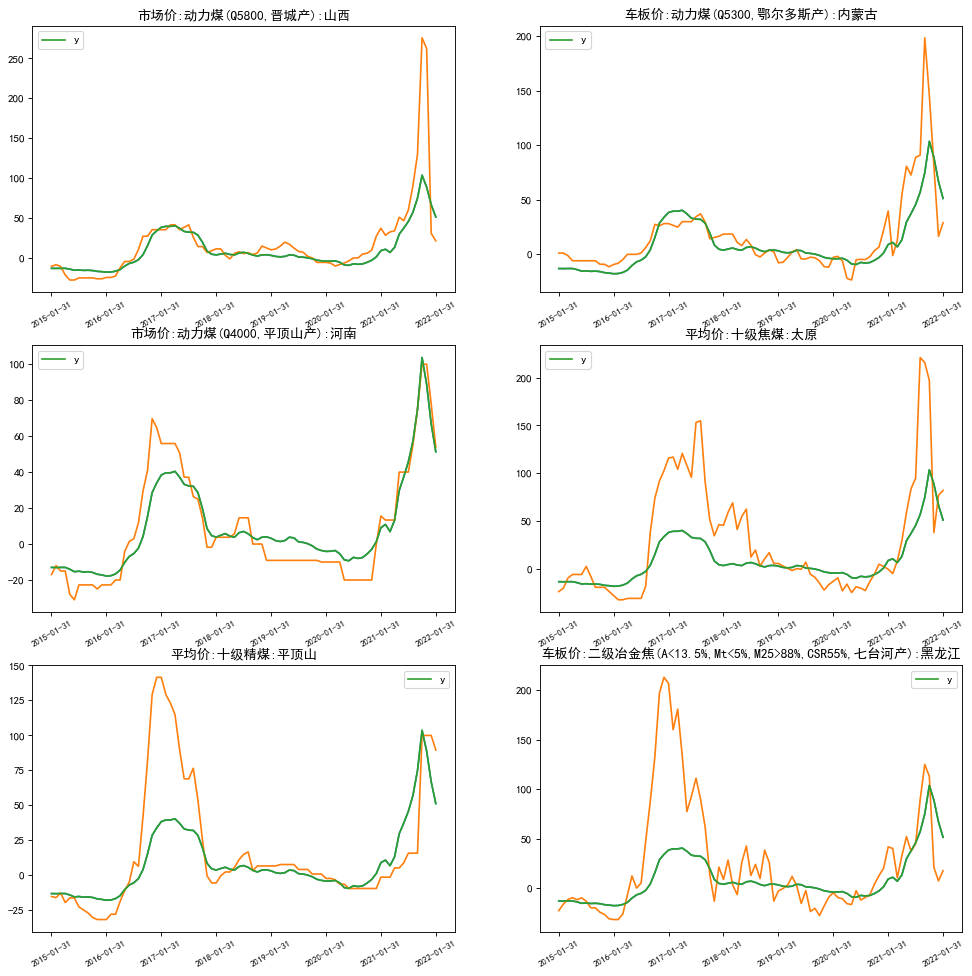

In [269]:
data = x_data[cmm[2]]
fig = plt.figure(figsize=(15,15),dpi=80)
print(pd.Series(cmm[2]),'\n')
print(mae_vif.iloc[2,:])
for i in range(data.shape[1]):
    tick_spacing = 12
    ax = fig.add_subplot(3,2,i+1)
#     plt.subplots_adjust(left = 0.01,right=0.8,wspace=0.2)
    ax.tick_params(axis='x', labelsize=8, rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.plot(y_data.index,y_data)
    ax.set_title(cmm[2][i])
    # ax.plot(y_test)
    ax.plot(data.index,data.iloc[:,i])
    ax.plot(y_data.index,y_data,label='y')
    plt.legend()

Del > 100: 
 15.588459836221114
Del > 60: 
 14.417520128436806
Del > 50: 
 16.435180067512956
Del > 40: 
 28.193741480961133
Del > 30: 
 40.24904139555081


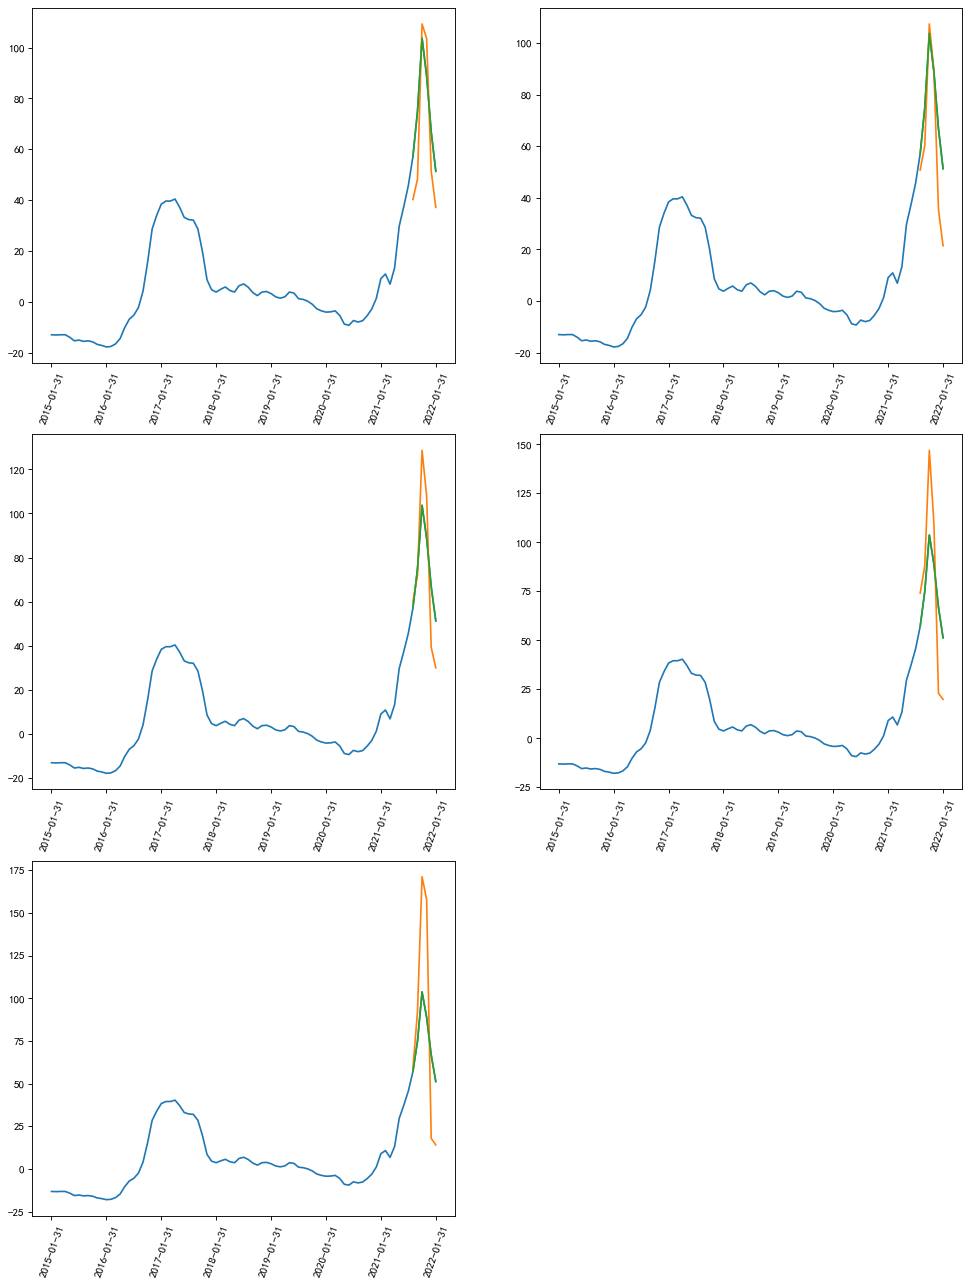

In [36]:
line = [100,60,50,40,30]
fig = plt.figure(figsize=(15,20),dpi=80)
for i in range(len(line)):
    x_vif = x_select[vif_table[vif_table.VIF< line[i]].index]
    las = Lasso(alpha = 1)
    gcv = GapWalkForward(n_splits = 5, gap_size = 2, test_size = 6)
    mae1=[]
        
    print('Del > '+str(line[i])+': \n',np.mean(mae1))
    
    tick_spacing = 12
    ax = fig.add_subplot(3,2,i+1)
    ax.tick_params(axis='x', labelsize=10, rotation=70)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.plot(y_data.index,y_data)

    # ax.plot(y_test)
    ax.plot(y_test.index,y_pred)
    ax.plot(y_test.index,y_test)
    